Training: 100%|██████████| 50000/50000 [01:03<00:00, 793.43iteration/s, Loss=0.9539]


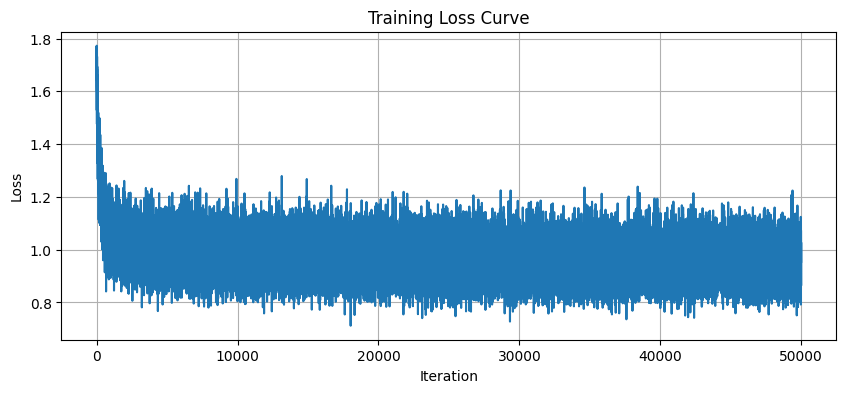

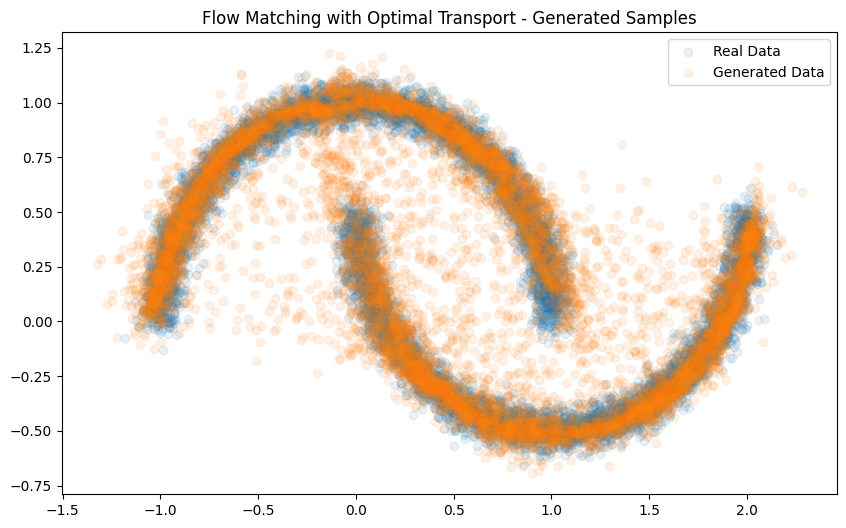


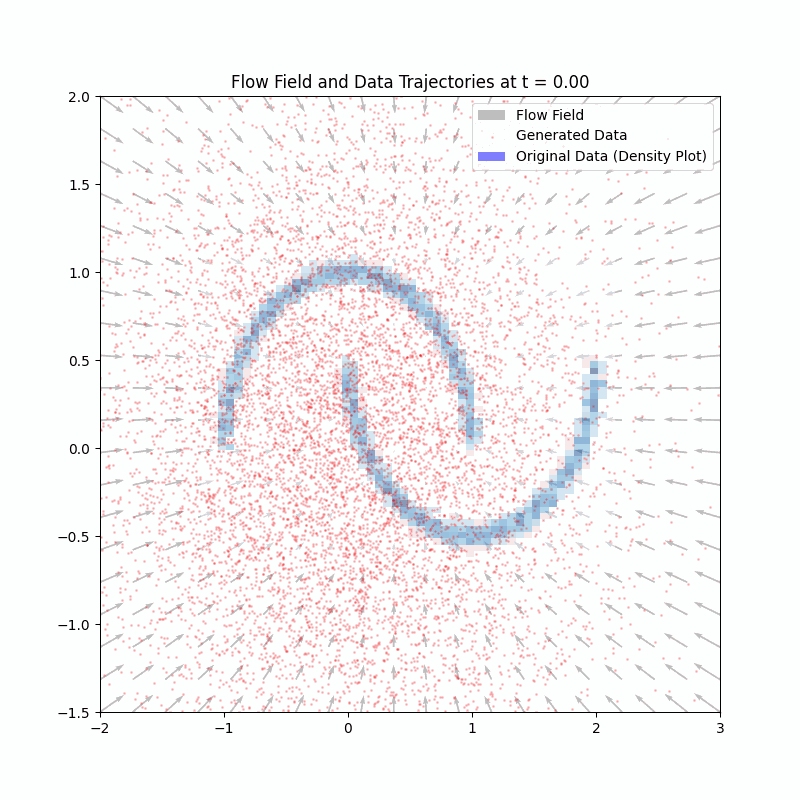

In [1]:
"""
Minimal PyTorch implementation of Flow Matching with Optimal Transport (OT) for generative modeling, based on "Flow Matching for Generative Modeling" by Lipman et al. (2023).

This code provides a simplified example using the half-moons dataset and Euler method for sampling.
"""

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from matplotlib.animation import FuncAnimation
from sklearn.datasets import make_moons
from tqdm import tqdm
import base64
from IPython.display import HTML


# Device configuration
device: torch.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
data_size: int = 10_000
batch_size: int = 256
input_dim: int = 2
hidden_dim: int = 64
n_iterations: int = 50_000  # Total number of iterations.
sigma_min: float = (
    1e-5  # For OT path (Eq. 22). Controls variance at t=1 (should be small).
)
lr: float = 2e-4

# Data #######################################################################
# Generate half moon data as toy dataset
data, _ = make_moons(data_size, noise=0.05)
data = torch.tensor(data, dtype=torch.float32).to(device)
data_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)


# Model ######################################################################
# Define the vector field network v_t
class VectorFieldNetwork(nn.Module):
    """
    Parametric model for the time-dependent vector field v_t(x; θ) (Section 3 in Lipman et al.).

    This network represents the function v_t(x; θ), which is the Continuous Normalizing Flow (CNF) vector field.
    It is used in the Flow Matching objective (Eq. 5 in Lipman et al.).
    The network outputs the *value* of the vector field at a given time t and point x.
    """

    def __init__(self, input_dim: int, hidden_dim: int):
        super().__init__()
        # MLP architecture (no specific architecture defined in the paper)
        self.net: nn.Sequential = nn.Sequential(
            nn.Linear(input_dim + 1, hidden_dim),  # +1 for time embedding
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
        )

    def time_embedding(self, t: torch.Tensor) -> torch.Tensor:
        """
        Embeds time into a higher dimensional space.
        """
        return t.unsqueeze(-1)  # Simple embedding, no frequencies used

    def forward(self, t: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
        """
        Computes the vector field v_t(x) at time t and point x.
        """
        t_emb: torch.Tensor = self.time_embedding(t)
        tx: torch.Tensor = torch.cat([t_emb, x], dim=-1)
        return self.net(tx)  # Output is v_t(x; θ) (Eq. 5 in Lipman et al.)


def ot_path(
    x_0: torch.Tensor,
    x_1: torch.Tensor,
    t: torch.Tensor,
    sigma_min: float,
) -> tuple[torch.Tensor, torch.Tensor]:
    """
    Computes the Optimal Transport (OT) path (ψ_t) and target vector field (u_t).

    This function implements the conditional flow ψ_t (Eq. 22 in Lipman et al.) and the corresponding target vector field u_t (Eq. 23 in Lipman et al.) for the Optimal Transport (OT) formulation in Flow Matching.  ψ_t defines a straight-line interpolation path between a sample x_0 from the prior distribution and a target data point x_1.  The target vector field u_t represents the ideal vector field that the learned vector field v_t should approximate.

    Args:
        x_0: Samples from the prior distribution (typically a standard Gaussian).
        x_1: Target data points.
        t: Time points along the OT path (between 0 and 1).
        sigma_min: Small constant controlling the variance at t=1 (see Eq. 22).

    Returns:
        A tuple containing the OT path (ψ_t) and the target vector field (u_t).
    """
    t = t.unsqueeze(-1)
    # ψ_t (Eq. 22 in Lipman et al.) Linear interpolation between prior and target.
    psi_t: torch.Tensor = (1 - (1 - sigma_min) * t) * x_0 + (t * x_1)
    # Target vector field for OT (u_t) (Eq. 23 in Lipman et al.)
    target_v: torch.Tensor = x_1 - (1 - sigma_min) * x_0
    return psi_t, target_v


def compute_cfm_loss(
    v_net: VectorFieldNetwork,
    x_0: torch.Tensor,
    x_1: torch.Tensor,
    t: torch.Tensor,
    sigma_min: float,
) -> torch.Tensor:
    """
    Computes the Conditional Flow Matching (CFM) loss for Optimal Transport.

    This function computes the CFM loss (Eq. 23 in Lipman et al.) using the Optimal Transport (OT) formulation.  It compares the predicted vector field v_t(ψ_t(x_0, x_1, t)) (output of the v_net) with the target vector field u_t derived from the OT path. The loss is calculated as the mean squared error (MSE) between the predicted and target vector fields.  Minimizing this loss encourages the learned vector field to accurately represent the OT flow.

    Args:
        v_net: The vector field network v_t(x; θ).
        x_0: Samples from the prior distribution.
        x_1: Target data points.
        t: Time points along the OT path.
        sigma_min: Small constant controlling the variance at t=1.

    Returns:
        The CFM loss as a scalar tensor.
    """
    psi_t, target_v = ot_path(x_0, x_1, t, sigma_min)
    v: torch.Tensor = v_net(t, psi_t)  # v_t(ψ_t(x_0, x_1, t))
    # CFM loss (Eq. 23 in Lipman et al.), simplified as MSE loss
    loss: torch.Tensor = ((v - target_v) ** 2).mean()
    return loss


# Training ###################################################################
# Initialize the vector field network v_t and optimizer
v_net = VectorFieldNetwork(input_dim, hidden_dim).to(device)
optimizer = optim.Adam(v_net.parameters(), lr=lr)

# Training loop
progress_bar = tqdm(range(n_iterations), desc="Training", unit="iteration")
losses = []  # List to store loss values
for iteration in progress_bar:
    x_1 = next(iter(data_loader))  # Sample data x_1 ~ q(x_1)
    t = torch.rand(x_1.shape[0], device=device)  # Sample time t ~ U[0, 1]
    x_0 = torch.randn_like(x_1)  # Sample prior noise x_0 ~ N(0, I)

    loss = compute_cfm_loss(v_net, x_0, x_1, t, sigma_min)  # CFM loss

    # Optimization step
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())  # Store the loss value
    progress_bar.set_postfix({"Loss": f"{loss.item():.4f}"})

# Plot loss curve after training
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(losses)
ax.set_xlabel("Iteration")
ax.set_ylabel("Loss")
ax.set_title("Training Loss Curve")
ax.grid(True)  # Add grid
plt.show()


# Sampling and Visualization ##################################################
def sample(
    n_samples: int,
    vector_field: VectorFieldNetwork,
    n_steps: int = 100,  # Number of steps for integration
) -> tuple[torch.Tensor, list[tuple[float, torch.Tensor]]]:
    """
    Generates samples by integrating the learned vector field.

    This function generates samples by numerically integrating the learned vector field `v_t(x)` from t=0 to t=1.  It uses the Euler method (a simple first-order numerical integration method) to approximate the solution to the ODE defined by the vector field (Eq. 1 in Lipman et al. with a simplified discretization).  The integration starts from random samples drawn from the prior distribution (typically a standard Gaussian).

    Args:
        n_samples: The number of samples to generate.
        vector_field: The learned vector field network v_t(x; θ).
        n_steps: The number of integration steps.

    Returns:
        A tuple containing:
            - A tensor of generated samples (the final state)
            - A list of tuples (t, x_t) representing the full trajectory.
    """
    trajectory = []

    x = torch.randn(n_samples, input_dim).to(device)  # Sample x_0 ~ N(0, I)
    trajectory.append((0.0, x.clone()))

    t_values = torch.linspace(0, 1, steps=n_steps)
    for i in range(1, n_steps):  # Euler integration from t=0 to t=1 (inclusive)
        t = t_values[i]
        t_batch = t.expand(n_samples).to(device)
        dt = t - t_values[i - 1]  # Calculate dt based on diff with previous step
        # Euler update (Eq. 28 in Lipman et al. with simplified discretization)
        x = x + vector_field(t_batch, x) * dt
        trajectory.append((t.item(), x.clone().detach()))

    return x, trajectory


def create_animations(
    n_samples: int,
    vector_field: VectorFieldNetwork,
    data: torch.Tensor,
    n_frames: int = 100,
):
    """
    Creates and saves animations of the sampling process.

    Args:
        n_samples: The number of samples to generate.
        vector_field: The learned vector field network v_t(x; θ).
        data: The original dataset.
        n_frames: Number of frames for the animation.
    """
    # Generate animation data using the sample function
    _, trajectory = sample(n_samples, vector_field, n_steps=n_frames)
    animation_data = trajectory  # Trajectory contains (t, x_t) tuples

    # Animation: Flow Field and Data Trajectories overlaid
    fig, ax = plt.subplots(figsize=(8, 8))

    n_grid_points = 20  # Reduced grid for smoother animation.
    x_grid, y_grid = torch.meshgrid(
        torch.linspace(-2, 3, n_grid_points),
        torch.linspace(-1.5, 2, n_grid_points),
        indexing="ij",
    )  # Expanded range
    grid = torch.stack([x_grid.flatten(), y_grid.flatten()], dim=-1).to(device)

    def update(frame):
        t, x_t = animation_data[frame]
        t_batch = torch.full((grid.shape[0],), t).to(device)
        flow: torch.Tensor = vector_field(t_batch, grid)

        # Clear previous frame
        ax.cla()

        # Flow Field plot
        quiver = ax.quiver(
            grid[:, 0].cpu().detach().numpy(),
            grid[:, 1].cpu().detach().numpy(),
            flow[:, 0].cpu().detach().numpy(),
            flow[:, 1].cpu().detach().numpy(),
            color="grey",
            alpha=0.5,
            label="Flow Field",
        )
        # Original data points as density plot
        hist = ax.hist2d(
            data[:, 0].cpu().numpy(),
            data[:, 1].cpu().numpy(),
            bins=50,
            cmap="Blues",
            alpha=0.5,
        )
        # Current state of generated samples
        generated = ax.scatter(
            x_t[:, 0].cpu().detach().numpy(),
            x_t[:, 1].cpu().detach().numpy(),
            s=1,
            alpha=0.2,
            color="red",
            label="Generated Data",
        )

        ax.set_title(f"Flow Field and Data Trajectories at t = {t:.2f}")
        ax.set_xlim([-2, 3])
        ax.set_ylim([-1.5, 2])

        # Add the legend
        handles = [quiver, generated]
        labels = ["Flow Field", "Generated Data"]
        proxy = plt.Rectangle((0, 0), 1, 1, fc="blue", alpha=0.5)
        handles.append(proxy)
        labels.append("Original Data (Density Plot)")
        ax.legend(
            handles=handles, labels=labels, loc="upper right", bbox_to_anchor=(1, 1)
        )

        return quiver, hist[3], generated

    # Add extra frames at the end to show the last frame longer
    extra_frames = 30  # Increased number of extra frames to show at the end

    def frame_generator(n_frames, extra_frames):
        for i in range(n_frames):
            yield i
        for _ in range(extra_frames):
            yield n_frames - 1  # Repeat the last frame

    total_frames = n_frames + extra_frames
    ani = FuncAnimation(
        fig,
        update,
        frames=frame_generator(n_frames, extra_frames),
        blit=True,
        repeat=True,
        save_count=total_frames,
    )

    ani.save(
        "flow_field_and_trajectories_combined.gif", writer="pillow", fps=20
    )  # Increased fps for smoother animation
    plt.close(fig)


# Generate samples
generated_samples, _ = sample(data_size, v_net)
generated_samples = generated_samples.cpu().detach().numpy()

# Plot the generated samples
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(
    data[:, 0].cpu().numpy(), data[:, 1].cpu().numpy(), label="Real Data", alpha=0.1
)
ax.scatter(
    generated_samples[:, 0], generated_samples[:, 1], label="Generated Data", alpha=0.1
)
ax.set_title("Flow Matching with Optimal Transport - Generated Samples")
ax.legend()
plt.show()

# Create animations
create_animations(data_size, v_net, data)

# Display the animation in the notebook
# Embed the GIF directly in the notebook by encoding the bytes as base64, this way it should hopefully also be exported
with open("flow_field_and_trajectories_combined.gif", "rb") as f:
    gif_data = f.read()
gif_base64 = base64.b64encode(gif_data).decode()

HTML(f'<img src="data:image/gif;base64,{gif_base64}">')